## Finding Relative Value Trades

The dataset linked to this notebook countains bonds prices for specific maturities and coupon rates. The aim of this analysis is first to estimate discount functions based on bootstrapping, cubic splines and the Nelson-Siegel-Svensson model. Additionaly, this analysis suggests a diversified zero cost long short strategy based on the mispricing of these bonds.

In [ ]:
import pandas as pd
from datetime import date
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# ----------- Cubic splines --------------------#
from scipy.interpolate import LSQUnivariateSpline
#---------- Nelson Siegel model ----------------#
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

PATH = 'data.xls'

### Bootstrapping

We solve for the prices of discount bonds given the market prices of coupon bonds and
identify the zero-coupon yields from the prices of zero-coupon bonds.

In [4]:
# Get the df from the excel file
initial_date = date(2003, 8, 15)
df_ex1 = pd.read_excel("data.xls", sheet_name="Exhibit 1", skiprows=1, header=1, parse_dates=['Maturity Date'])[:-2]
df_ex1['Maturity'] = (df_ex1['Maturity Date'] - pd.to_datetime(initial_date)).dt.days / 365
df_ex1['Maturity'] = df_ex1['Maturity'].round(1)

df_ex1.head()

,Coupon Rate (%),Maturity Date,Current Price,Maturity
0,3,2004-02-15,101.0544,0.5
1,2.125,2004-08-15,100.9254,1.0
2,1.5,2005-02-15,99.8942,1.5
3,6.5,2005-08-15,109.0934,2.0
4,5.625,2006-02-15,108.4380,2.5


In [5]:
freq = 2  # Assuming semi-annual coupon payments
zero_coupon_yield_list = []

# Compute the zero coupon yield
def zero_coupon_yield(maturity: float, coupon: float, current_price: float):
    # Compute the number of cash flows (i.e., periods based on maturity and frequency)
    sum_cash_flows = 0
    number_of_cash_flows = int(maturity * freq) # Multiply maturity in years by frequency (e.g., 2 for semi-annual)

    if zero_coupon_yield_list:
        for i in range(1, number_of_cash_flows):
            # Discount each coupon payment by the appropriate zero-coupon yield for that period
            cash_flow = (coupon / freq) / (1 + zero_coupon_yield_list[i-1] / freq)**i
            sum_cash_flows += cash_flow

    # Remaining price after deducting coupon cash flows
    remaining_price = current_price - sum_cash_flows

    # Calculate zero-coupon yield (final maturity value and last coupon discounted)
    zero_coupon_yield = (((100 + (coupon / freq)) / remaining_price)**(1 / number_of_cash_flows) - 1) * freq
    zero_coupon_yield_list.append(zero_coupon_yield)

    return zero_coupon_yield

# Apply function to the DataFrame
df_ex1['Zero Coupon Yield'] = df_ex1.apply(lambda row: zero_coupon_yield(row['Maturity'], row['Coupon Rate (%)'], row['Current Price']), axis=1)

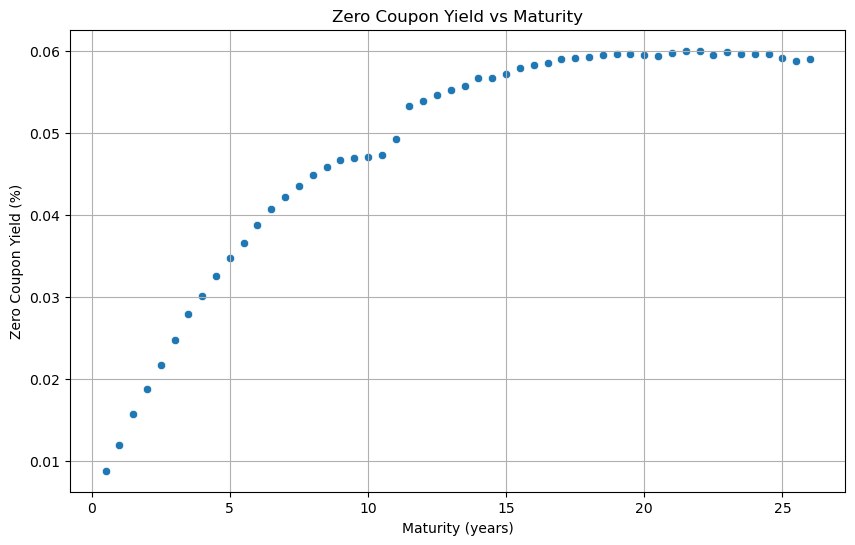

In [6]:
# Plot results 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Maturity', y='Zero Coupon Yield', data=df_ex1, marker='o')
plt.title('Zero Coupon Yield vs Maturity')
plt.xlabel('Maturity (years)')
plt.ylabel('Zero Coupon Yield (%)')
plt.grid(True)
plt.show()

We compare the zero-coupon yields from the dataset model (in Exhibit 4 of the case) to
the market zero-coupon yields, and identify which zero-coupon bonds Deutsche Bank
should buy, and which ones they should sell.

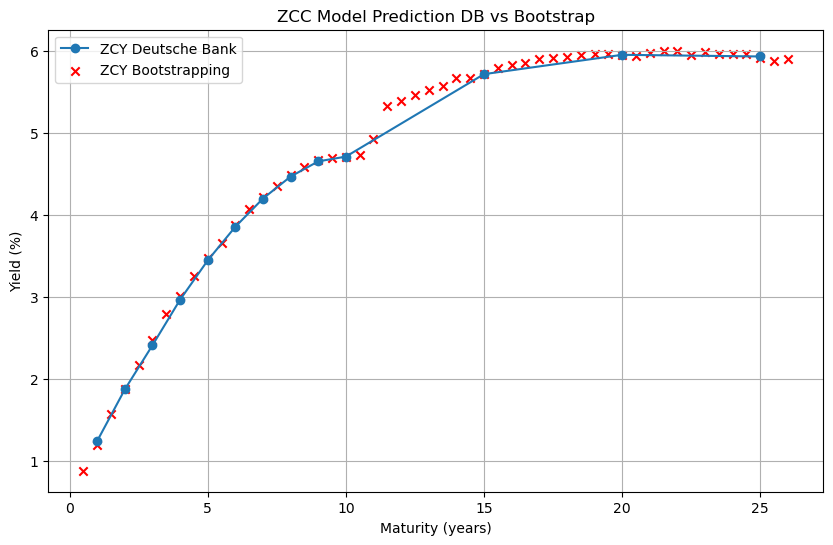

In [7]:
#Import curve from Exhibit 4 from Deutshe Bank
df_ex4 = pd.read_excel("data.xls", sheet_name="Exhibit 4 ", skiprows=1, header=1)[:-4]
df_ex4['Model Prediction'] = df_ex4['Model Prediction (BEY)'].str.rstrip('%').astype('float') / 100.0

# Convert 'Maturity (years)' in df_ex4 to numeric values
df_ex4['Maturity (years)'] = df_ex4['Maturity (years)'].str.rstrip('y').astype(float)

# Plot the two curves together
plt.figure(figsize=(10, 6))
plt.plot(df_ex4['Maturity (years)'], df_ex4['Model Prediction'] * 100, marker='o', label='ZCY Deutsche Bank')
plt.scatter(df_ex1['Maturity'], df_ex1['Zero Coupon Yield'] * 100, marker='x', label='ZCY Bootstrapping', color='red')
plt.title('ZCC Model Prediction DB vs Bootstrap')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()

Deutsche Bank should buy bonds where the market zero-coupon yields are higher than those predicted by their model, as these bonds are likely undervalued. Conversely, they should sell bonds where the market yields are lower than the model’s predictions, suggesting overvaluation. For example, bonds with maturities around 10-15 years show higher market yields, which would be buy opportunities.

However, this strategy is not risk-free arbitrage. Beyond interest rate risk, model risk, and liquidity risk, it's crucial to recognize that older bonds, especially those that are off-the-run (i.e., no longer the most recent issuance), can be less liquid and harder to trade compared to on-the-run (benchmark) bonds. These older bonds may be rarer in the market, and their lower liquidity often commands a premium, which is reflected in their repo rates. As a result, executing buy or sell decisions for these bonds could be more challenging and expensive. Additionally, transaction costs and the potential difficulty in sourcing these bonds could significantly reduce the anticipated profits from the strategy. Managing these factors carefully, particularly the liquidity and availability of bonds in the repo market, is essential to the successful execution of this approach.

### Cubic splines

In this section, we estimate the cubic splines’ function that uses as knots 2-, 5-,10-, 15- and 20-year zerocoupon yields.

In [ ]:
def fit_cubic_spline(df, knots):
    # Create LSQ Univariate Spline interpolation based on the knots and their yields
    cubic_spline = LSQUnivariateSpline(df['Maturity'], df['Zero Coupon Yield'], knots, k=3)

    # Define a fine range of maturities for smooth plotting and get the interpolated yields
    fine_maturities = np.linspace(df['Maturity'].min(), df['Maturity'].max(), 500)
    spline_yields = cubic_spline(fine_maturities)
    
    return fine_maturities, spline_yields

# Define the knots for the cubic spline (2-, 5-, 10-, 15-, and 20-year maturities)
knots = [2, 5, 10, 15, 20]
fine_maturities, spline_yields = fit_cubic_spline(df_ex1, knots)

This method fits a cubic spline (k=3) to the data, using specified internal knots at 2, 5, 10, 15, and 20-year maturities. The spline is constrained to pass precisely through these specified knot points, ensuring the curve accurately reflects these maturities. Between the knots, the spline smoothly interpolates the yield curve without being forced through any other maturities.

To create a smooth, continuous plot, we evaluate the spline over 500 equally spaced points across the maturity range, providing a fine-grained and visually continuous yield curve.

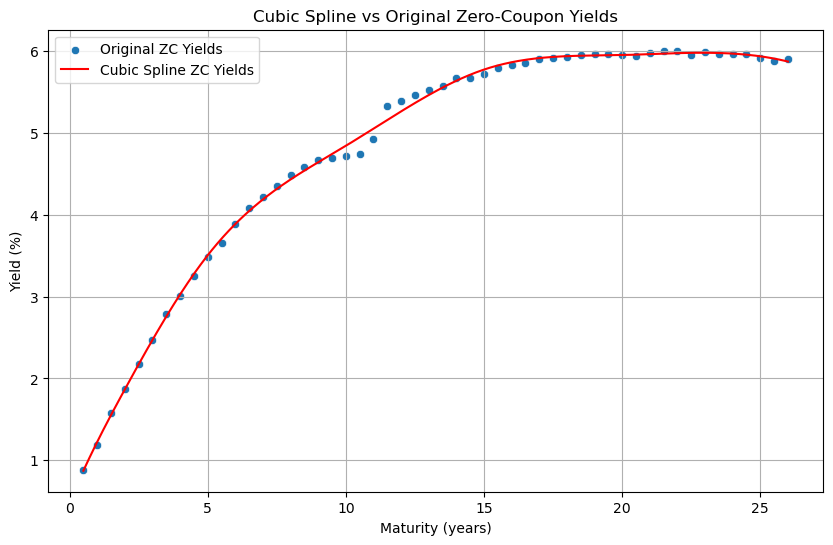

In [9]:
# Plot the original zero-coupon yields vs. the cubic spline yields
def plot_spline_vs_original(fine_maturities, spline_yields, maturities, zero_coupon_yields):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=maturities, y=zero_coupon_yields * 100, marker='o', label='Original ZC Yields')
    sns.lineplot(x=fine_maturities, y=spline_yields * 100, label='Cubic Spline ZC Yields', color='red')
    plt.title('Cubic Spline vs Original Zero-Coupon Yields')
    plt.xlabel('Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_spline_vs_original(fine_maturities, spline_yields, df_ex1['Maturity'], df_ex1['Zero Coupon Yield'])

The cubic spline is more appropriate when we are talking about liquid maturities and where there are multiple maturities close to each other. This is due to the fact that the boostrapping method doesn't try to smooth the curve and maybe produce some local small jumps . By reading this curve, you may interpret those jumps as potential buy or sell opportunity. However, with the cubic spline, the interpolation is smoother and represents more accurately the gradual change of yield accross time. 
When we are looking at markets with fewer observed points or irregular yield movements, bootstrapping may better capture abrupt changes due to supply-demand factors or market anomalies, which might not be as well represented by a spline. The market may be representing some specific risk for a range of maturity, creating a local dynamic and if the spline doesn't have a knot in this area, it will fail to capture it due to it's nature.

The best example here is the 10 to 15 year maturities : when looking at the boostrap, we can clearly see the jump around 11-12 year that may indicate a buy opportunity in this area. 
However, when using the cubic spline, the closest know we are using in this area at 10 and 15 year. This mean we model will produce a smooth curve between those two points, regardless of the granularity of the yield in between. 

In our opinion, it doesn't really change the conclusions of the question 1.2, the bank has just to be aware of both models limitation and knowing which one to use for given conditions ! Using cubic spline wouldn't not signal buy the bonds we mentionned in Q1.2, but this is because the model is less appropriate in this case.

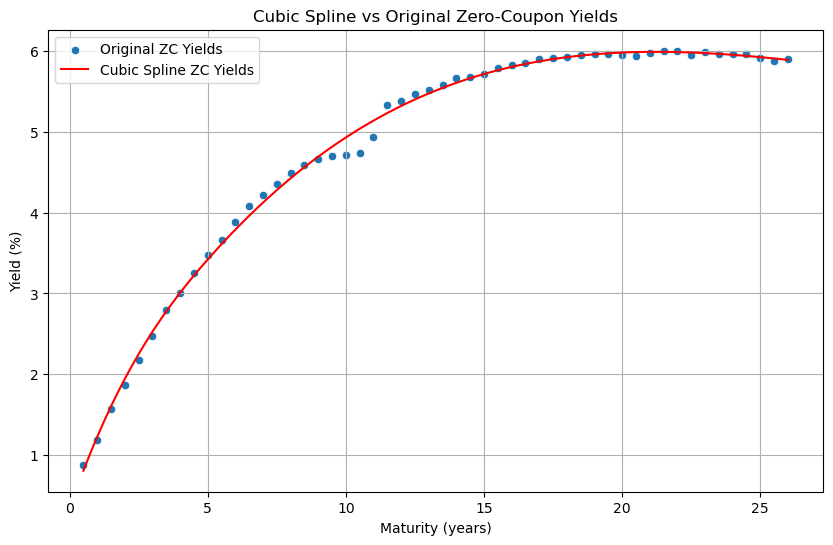

In [10]:
# We do the same changing the knots with only 5- and 20-years maturities.
knots = [5, 20]
fine_maturities, spline_yields = fit_cubic_spline(df_ex1, knots)

plot_spline_vs_original(fine_maturities, spline_yields, df_ex1['Maturity'], df_ex1['Zero Coupon Yield'])

When using knots only at the 5-year and 20-year maturities, the cubic spline model provides a general approximation of the yield curve’s shape but fails to capture crucial local variations, particularly around the 10-year mark. The model’s limited knots result in a smoother curve that overlooks fluctuations in the intermediate term, especially between the 9-year and 13-year maturities. As a result, the model adequately fits maturities beyond 13 years but lacks precision in representing the curve’s structure in the mid-range, where there is a notable dip in the yield data.

This limitation reflects how reducing the number of knots can simplify the model to the detriment of accuracy, especially in regions with significant yield curve inflections. By omitting intermediate knots, the model underestimates the curve’s complexity and fails to accommodate fluctuations that are essential for modeling the yield curve’s dynamic nature, particularly around the 10-year maturity.

To improve the model, adding intermediate knots at key points—such as around 10 years—would better capture the curve’s true shape. This would allow for a more accurate representation of the yield curve without oversimplifying important trends. However, care must be taken to avoid excessive knots, which could lead to overfitting and reduce the model's generalizability. The objective is to balance the selection of knot points to enhance accuracy without replicating the granular fit of a bootstrap approach, thereby preserving the advantages of smooth interpolation.

## Nelson-Siegel-Svensson model

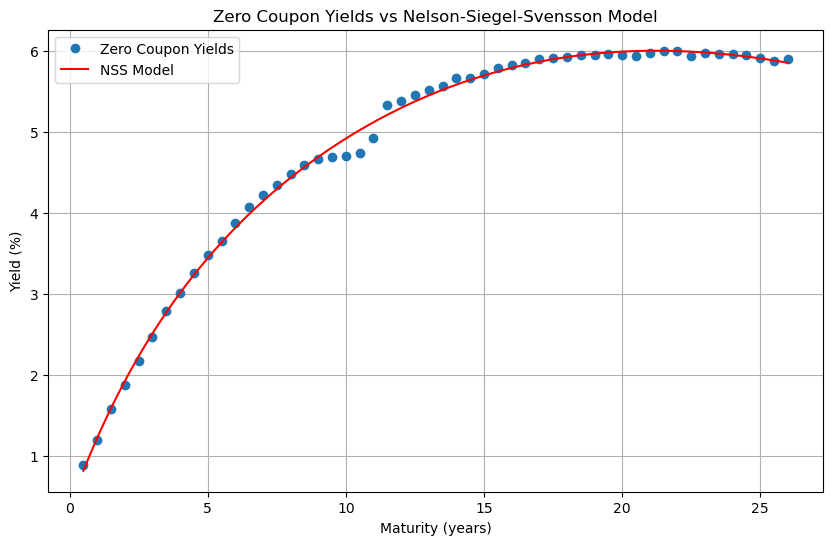

In [ ]:
# Define the Nelson-Siegel-Svensson model
def nss_model(t, beta0, beta1, beta2, beta3, lambda1, lambda2):
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-lambda1 * t)) / (lambda1 * t)
    term3 = beta2 * ((1 - np.exp(-lambda1 * t)) / (lambda1 * t) - np.exp(-lambda1 * t))
    term4 = beta3 * ((1 - np.exp(-lambda2 * t)) / (lambda2 * t) - np.exp(-lambda2 * t))
    return term1 + term2 + term3 + term4

# Initial guess for the parameters and fit the NSS model to the zero-coupon yields
initial_guess = [0.03, -0.02, 0.02, 0.01, 1.0, 1.0]
params, _ = curve_fit(nss_model, df_ex1['Maturity'], df_ex1['Zero Coupon Yield'], p0=initial_guess)

# Generate the fitted yields using the estimated parameters
fitted_yields = nss_model(fine_maturities, *params)

# Plot the zero-coupon yields and the fitted NSS model
plt.figure(figsize=(10, 6))
plt.plot(df_ex1['Maturity'], df_ex1['Zero Coupon Yield'] * 100, 'o', label='Zero Coupon Yields')
plt.plot(fine_maturities, fitted_yields * 100, '-', label='NSS Model', color='red')
plt.title('Zero Coupon Yields vs Nelson-Siegel-Svensson Model')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

This code implements and fits the Nelson-Siegel-Svensson (NSS) model to approximate the zero-coupon yield curve. The nss_model function breaks down the yield curve into four distinct components, each shaped by the parameters beta0, beta1, beta2, beta3, lambda1, and lambda2, which together capture the yield curve’s level, slope, and curvature characteristics. Specifically:

- beta0 represents the long-term level of the yield curve.
- beta1 controls the slope, typically affecting short-term yields.
- beta2 and beta3 adjust the curvature, influencing intermediate yields.
- lambda1 and lambda2 are decay factors that influence how quickly the slope and curvature components transition over different maturities

Using curve_fit, the model optimizes these parameters by fitting them to the observed zero-coupon yields. Once the fitting is done, the parameters are used to compute the fitted yields over a range of maturities. The NSS model creates a smooth curve that represents the overall yield curve without forcing it to pass through each individual data point, reflecting the underlying structure of the curve's level, slope, and curvature.

While this approach smooths the yield curve, a limitation appears around the 8-11 year maturities, where the model’s structure can lead to overestimations and cause a slight underestimation in the subsequent 11-13 year range. These biases may impact relative value analyses, as local variations are not fully captured in these segments. An effective improvement could involve applying the NSS model over smaller, localized maturity ranges—using subsets of maturities (e.g., six points at a time)—and averaging the results to create a more granular approximation. I applied this method during a previous internship on a bond trading desk, and it was highly appreciated for providing a more accurate approximation.

The Nelson-Siegel-Svensson (NSS) model and the cubic spline model represent two distinct approaches to yield curve fitting, each with unique strengths and limitations. The NSS model produces a smooth curve that captures the overall yield curve structure by modeling its level, slope, and curvature, without needing to pass through specific data points. This flexibility makes it well-suited for capturing broader yield curve dynamics, especially over longer maturities, where smoothness and trend continuity are prioritized.

In contrast, the cubic spline model excels at capturing localized movements between closely spaced maturities (such as the 2-6 year range) due to its knot-based structure. However, this structure can lead to overfitting at the specified knot points, which forces the curve to align at these specific maturities (e.g., the 10-year mark). This rigid alignment often prevents the model from accurately representing local variations and may distort the yield curve at the shorter and longer ends.

Overall, the NSS model offers a more adaptable and realistic yield curve representation, particularly when covering a broad maturity range. Its design allows it to better capture the general shape of the yield curve, making it ideal for applications that require a smooth, overarching view rather than a detailed alignment with specific maturities.

We estimate and plot the factor loadings and contributions from the different factors affecting
the shape of the spot zero-coupon curve.

In [12]:
# Display the parameters and their corresponding variables
param_names = ['beta0', 'beta1', 'beta2', 'beta3', 'lambda1', 'lambda2']
param_values = params

for name, value in zip(param_names, param_values):
    print(f"{name}: {value}")


beta0: -0.13975641184820958
beta1: 0.14343919558672738
beta2: 0.08819760780763944
beta3: 0.5491774235219888
lambda1: 0.24629974342688665
lambda2: 0.05902331479003359


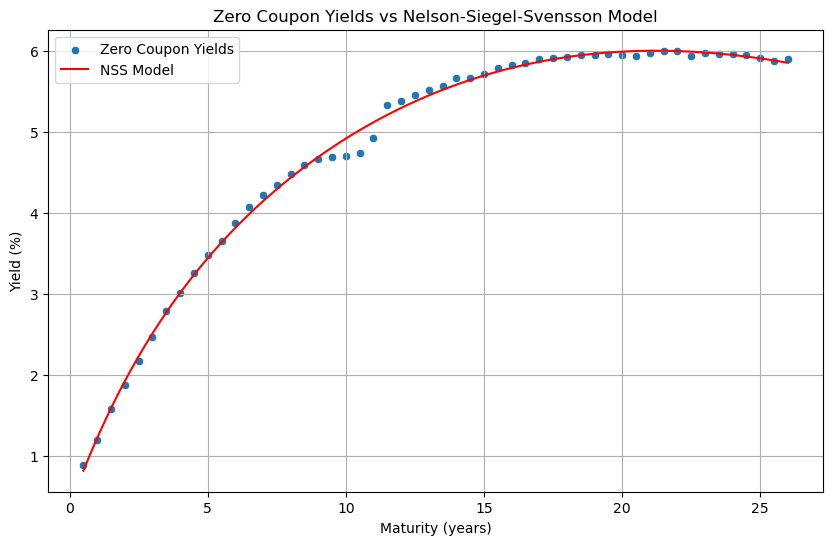

In [13]:
# Plot the zero-coupon yields and the fitted NSS model
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_ex1['Maturity'], y=df_ex1['Zero Coupon Yield'] * 100, label='Zero Coupon Yields')
sns.lineplot(x=fine_maturities, y=fitted_yields * 100, label='NSS Model', color='red')
plt.title('Zero Coupon Yields vs Nelson-Siegel-Svensson Model')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

In the Nelson-Siegel-Svensson (NSS) model, each parameter offers insights into different aspects of the yield curve’s shape. **Beta0** represents the long-term rate level, and while its value here is -0.1397, which suggests negative rates, the yield curve itself stabilizes around 5-6% for longer maturities. This implies that **Beta0 captures a positive baseline level** for the yield curve over the long term, aligning with observed stable positive rates in the plot.

**Beta1 (0.1434)** governs the slope, and its positive value reflects **an upward-sloping yield curve—indicating that shorter maturities start at lower rates and increase over time**. **Beta2 (0.0882)** influences the curvature, indicating a hump in the medium-term maturities (around 5-10 years), where yields rise to a peak before leveling off. **Beta3 (0.5491)** introduces additional flexibility, potentially **capturing more complex shapes in the longer-term section**, such as a second hump or further curvature.

**The lambda1 (0.2463)** and **lambda2 (0.0590)** parameters determine the decay rates of the slope and curvature effects, respectively. **The relatively higher value of lambda1** indicates that the upward slope extends for a more sustained period, while **the lower lambda2 suggests that the curvature introduced by Beta3 is localized and diminishes more quickly**.

In summary, this NSS model effectively represents the yield curve’s essential dynamics: an upward slope, a medium-term hump, and some additional complexity in the long end, creating a smooth and realistic approximation of the actual curve.

## Hedging

To estimate the sensitivity of any instrument or portfolio to the 10-year rate changes, i.e.,
its 10-year key rate duration (KRD), you will shock the 10-year rate by 50bps.

In [14]:
# Apply function to the DataFrame
df_ex4 = df_ex1.copy()
bump_tuple = (10, 0.005)

# Adjust the zero coupon yield based on bump_tuple
maturity, bump = bump_tuple
df_ex4.loc[df_ex4['Maturity'] == maturity, 'Zero Coupon Yield'] += bump

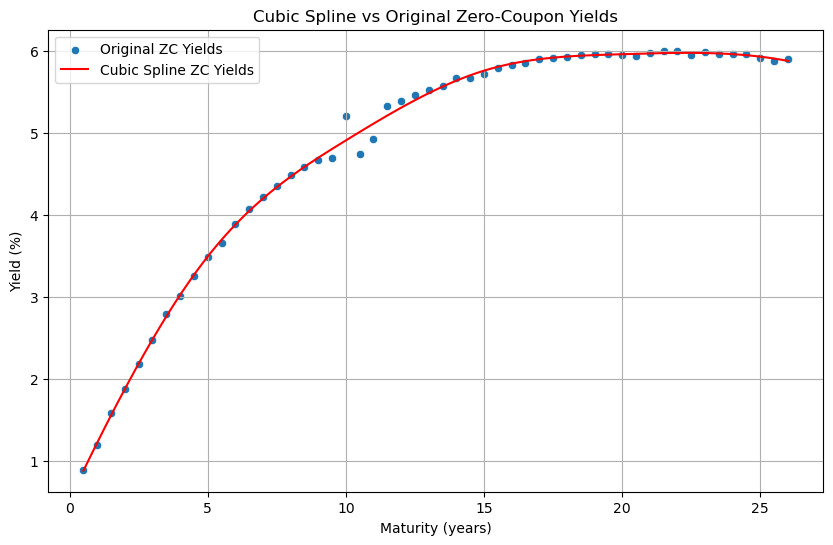

In [15]:
# Define the knots for the cubic spline (2-, 5-, 10-, 15-, and 20-year maturities)
knots = [2, 5, 10, 15, 20]
fine_maturities_cubic, spline_yields_cubic = fit_cubic_spline(df_ex4, knots)

plot_spline_vs_original(fine_maturities_cubic, spline_yields_cubic, df_ex4['Maturity'], df_ex4['Zero Coupon Yield'])

Shocking the 10-year rate by 50 bps significantly impacts the yield at that maturity, pushing the data point above the cubic spline curve, whereas it was positioned below it in question 2.1. However, an interesting aspect of the cubic spline model becomes evident here: while the 10-year data point shifts due to the rate shock, the overall cubic spline curve remains largely unchanged, failing to adjust fully to fit the new data point.

This behavior reflects a fundamental characteristic of cubic splines, which are designed to produce a smooth, continuous curve through specified knots rather than respond dynamically to individual points. As a result, any single-point adjustment—like the 50 bps shock at 10 years—does not shift the curve substantially because the model’s shape is constrained by its fixed knots (often at broader intervals, e.g., 5, 10, and 20 years).

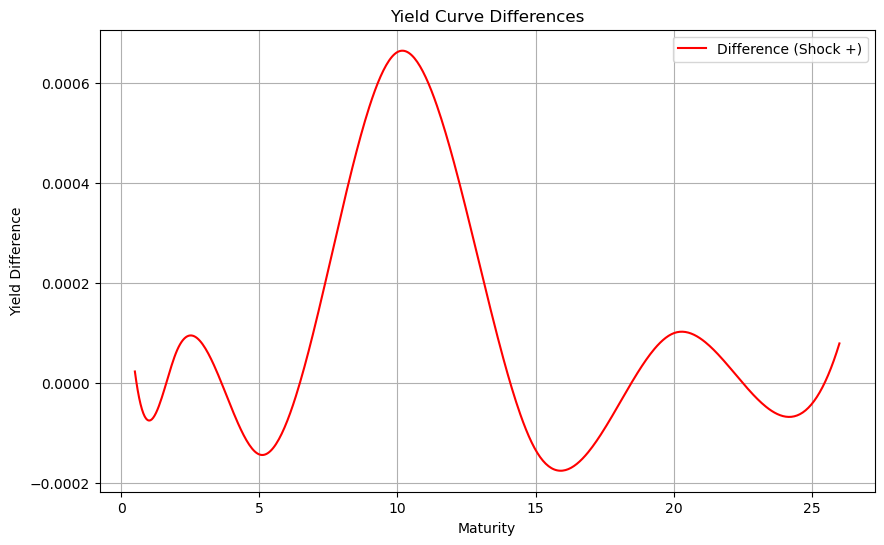

In [16]:
fine_maturities, spline_yields = fit_cubic_spline(df_ex1, knots)

# Calculate and Plot the differences between the two curves
diff_shocked_plus = spline_yields_cubic - spline_yields 
plt.figure(figsize=(10, 6))
plt.plot(fine_maturities, diff_shocked_plus, label='Difference (Shock +)', color='red')
plt.xlabel('Maturity')
plt.ylabel('Yield Difference')
plt.title('Yield Curve Differences')
plt.legend()
plt.grid(True)

plt.show()

Let's assume you own a 1 million $ portfolio that is equally invested in all bonds. What is the
KRD of our portfolio to this scenario?

In [17]:
# Define constants and prepare DataFrame
df_ex4_2 = df_ex1.copy()
freq = 2  
zero_coupon_yield_index = df_ex4_2[['Maturity', 'Zero Coupon Yield']]
bump_tuple = (10, 0.005)  # (maturity, bump (%))

# Define price change function
def price_change(maturity: float, coupon: float, current_price: float, zero_coupon_yield_index: pd.DataFrame, bump_tuple: tuple):
    # Compute the number of cash flows
    new_bond_price = 0
    number_of_cash_flows = int(maturity * freq)
    zero_coupon_yield_index_prov = zero_coupon_yield_index.copy()

    # Apply bump to zero coupon yields as per bump_tuple
    bump_maturity, bump = bump_tuple
    zero_coupon_yield_index_prov.loc[zero_coupon_yield_index_prov['Maturity'] == bump_maturity, 'Zero Coupon Yield'] += bump

    # Calculate bond price after applying bump
    for i in range(number_of_cash_flows):
        # Get the corresponding zero-coupon yield for the period
        yield_for_period = zero_coupon_yield_index_prov.iloc[i]['Zero Coupon Yield']
        
        # Calculate cash flow
        cash_flow = (100 if i == number_of_cash_flows -1 else 0) + coupon / freq
        discounted_cash_flow = cash_flow / (1 + yield_for_period / freq) ** (i + 1)
        
        # Sum discounted cash flows
        new_bond_price += discounted_cash_flow

    # Calculate price change percentage
    total_price_change = (new_bond_price - current_price) / current_price 
    return total_price_change

# Apply function to each row in the DataFrame
df_ex4_2['Price Change (%)'] = df_ex4_2.apply(
    lambda row: price_change(row['Maturity'], row['Coupon Rate (%)'], row['Current Price'], zero_coupon_yield_index, bump_tuple),
    axis=1
)

In [18]:
# Calculate the percentage change in price and create a new column
total_price_change = round(df_ex4_2['Price Change (%)'].sum() / df_ex4_2.shape[0] * 1_000_000, 2)
print(total_price_change)

-1169.34


The portfolio’s Key Rate Duration (KRD) to a 50 bps upward shock in the 10-year yield results in a value change of -1,169.34. This indicates that the portfolio would lose approximately $1,169 if the 10-year rate increased by 50 basis points, reflecting a negative sensitivity to movements at this key maturity. By calculating each bond’s price adjustment under the rate shock and averaging the changes, we capture the portfolio's specific exposure to the 10-year rate, showing a moderate level of interest rate risk focused around this maturity.

In [19]:
# Loop through each maturity in df_ex1 and compute total_price_change
total_price_changes = []
for maturity in df_ex4_2['Maturity']:
    bump_tuple = (maturity, bump)
    df_ex4_2['Price Change (%)'] = df_ex4_2.apply(
        lambda row: price_change(row['Maturity'], row['Coupon Rate (%)'], row['Current Price'], zero_coupon_yield_index, bump_tuple),
        axis=1
    )
    total_price_change = df_ex4_2['Price Change (%)'].sum() / df_ex4_2.shape[0] * 1_000_000
    total_price_changes.append(total_price_change)

# Add the Total Portfolio Changes as a new column in df_ex4_2
df_ex4_2.drop('Price Change (%)', axis=1, inplace=True)
df_ex4_2['Total Portfolio Change'] = total_price_changes

We estimate and plot the KRDs of our portfolio for all maturities, when applying the same
shock individually to all zero-coupon yields.

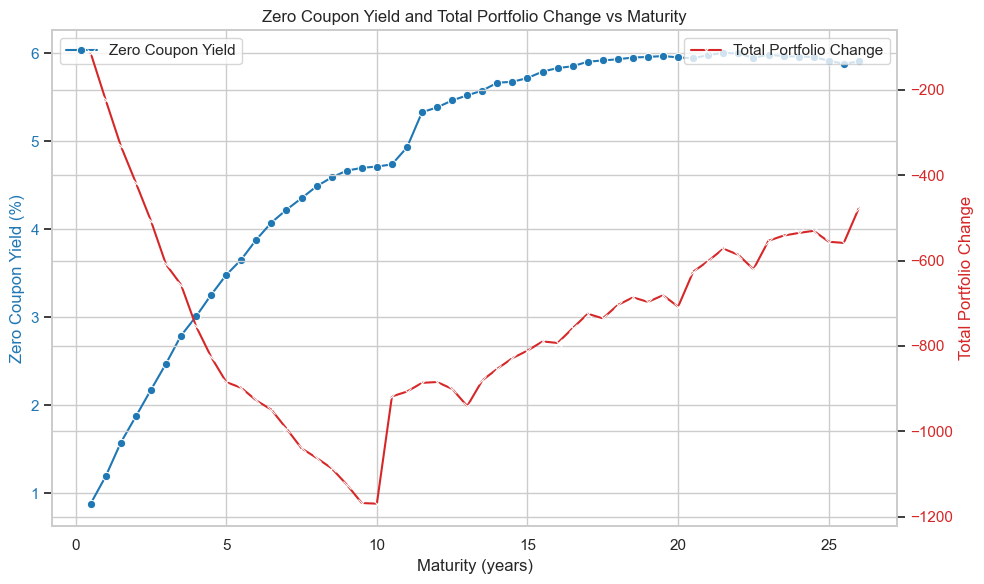

In [20]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Zero Coupon Yield on the first y-axis
ax1.set_xlabel('Maturity (years)')
ax1.set_ylabel('Zero Coupon Yield (%)', color='tab:blue')
sns.lineplot(x=df_ex4_2['Maturity'], y=df_ex4_2['Zero Coupon Yield'] * 100, marker='o', color='tab:blue', label='Zero Coupon Yield', ax=ax1)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot Total Portfolio Change
ax2 = ax1.twinx()
ax2.set_ylabel('Total Portfolio Change', color='tab:red')
sns.lineplot(x=df_ex4_2['Maturity'], y=df_ex4_2['Total Portfolio Change'], marker='x', color='tab:red', label='Total Portfolio Change', ax=ax2)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and show the plot
plt.title('Zero Coupon Yield and Total Portfolio Change vs Maturity')
fig.tight_layout()
plt.show()

To estimate the Key Rate Durations (KRDs) across all maturities in my portfolio, we applied a 50 bps shock individually to each zero-coupon yield and measured the resulting impact on portfolio value. The results show that the 10-year maturity exerts the highest impact, significantly more than neighboring maturities. This heightened sensitivity is largely due to the lower 4% coupon rate on the 10-year bond compared to, for instance, the 13% coupon on the 10.5-year bond. With a lower coupon, the bond’s cash flows are more concentrated in the principal payment, making its duration longer and increasing its exposure to changes in yield. Consequently, the 10-year bond’s higher duration amplifies the effect of rate shocks on its price, which in turn results in a more substantial impact on the overall portfolio value compared to higher-coupon, shorter-duration bonds. This analysis highlights how both coupon rates and bond maturities influence the portfolio's response to yield changes across the curve.

## Portfolio strategy

In this section, we assume we expect some steepening of the curve in the near future. We wnat to build a long short strategy based on the current yield curve

Lets apply a steepening transformation of the yield curve

𝑦_steep = 𝑦_current + [(𝑇 − mean(𝑇) ) / mean(𝑇) ∗ 0.0050] + 𝜀
* 𝜀 ~ 𝑁(0, 0.0025) : represents some noise in the steepening expectation
* mean(T) is the mean of the maturities we were asked to analyse

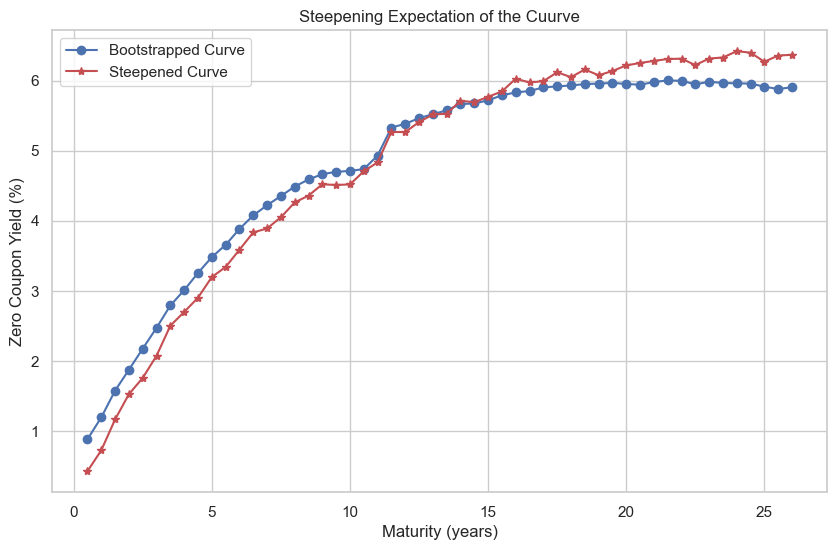

In [ ]:
# we set the seed for reproductivity
np.random.seed(42)

maturity_parameter = 0.005
noise_parameter = 0.0025
maturities_mean = df_ex1['Maturity'].mean()
df = pd.DataFrame()
df['Maturity'] = df_ex1['Maturity']
df['Coupon Rate (%)'] = df_ex1['Coupon Rate (%)']
df['Current Price'] = df_ex1['Current Price']
deterministic_component = df_ex1['Zero Coupon Yield'] + (df_ex1['Maturity'] - maturities_mean) / maturities_mean * maturity_parameter
noise = np.random.normal(0, np.sqrt(noise_parameter), len(df)) / 100
df['Steep. Yield'] = deterministic_component + noise

plt.figure(figsize=(10, 6))

plt.plot(df_ex1['Maturity'], df_ex1['Zero Coupon Yield'] * 100, marker='o', label='Bootstrapped Curve')
plt.plot(df['Maturity'], df['Steep. Yield'] * 100, marker='*', color='r', label='Steepened Curve')
plt.title('Steepening Expectation of the Cuurve')
plt.xlabel('Maturity (years)')
plt.ylabel('Zero Coupon Yield (%)')
plt.grid(True)
plt.legend()
plt.show()

The yield transformation produces a steepening of the curve as it is expected

We re-estimate the discount function using the Nelson-Siegel-Svensson methodology.

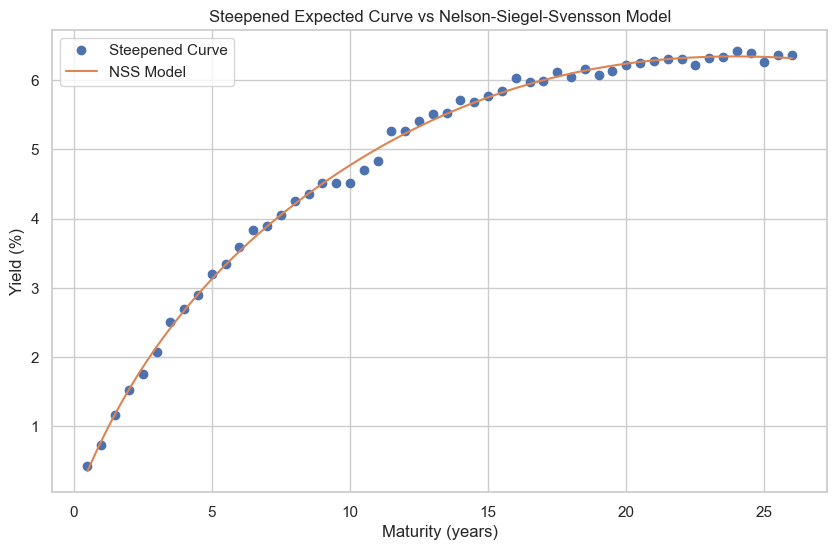

In [ ]:
# Define the Nelson-Siegel-Svensson model
def nss_model(t, beta0, beta1, beta2, beta3, lambda1, lambda2):
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-lambda1 * t)) / (lambda1 * t)
    term3 = beta2 * ((1 - np.exp(-lambda1 * t)) / (lambda1 * t) - np.exp(-lambda1 * t))
    term4 = beta3 * ((1 - np.exp(-lambda2 * t)) / (lambda2 * t) - np.exp(-lambda2 * t))
    return term1 + term2 + term3 + term4

# Initial guess for the parameters and fit the NSS model to the zero-coupon yields
initial_guess = [0.03, -0.02, 0.02, 0.01, 1.0, 1.0]
params, _ = curve_fit(nss_model, df['Maturity'], df['Steep. Yield'], p0=initial_guess)

# Generate the fitted yields using the estimated parameters
fitted_yields = nss_model(fine_maturities, *params)

# Plot the zero-coupon yields and the fitted NSS model
plt.figure(figsize=(10, 6))
plt.plot(df['Maturity'], df['Steep. Yield'] * 100, 'o', label='Steepened Curve')
plt.plot(fine_maturities, fitted_yields * 100, '-', label='NSS Model')
plt.title('Steepened Expected Curve vs Nelson-Siegel-Svensson Model')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

Let's extract the yields given by the Nelson-Siegel-Svensson for the specific maturities we focus on

In [ ]:
# Create an interpolation function for the larger dataframe
interp_func = interp1d(fine_maturities, fitted_yields, kind='linear', fill_value='extrapolate')

# Interpolate yields for the maturities in the smaller dataframe
df['NSS Yield'] = interp_func(df['Maturity'])
df.sample(5)

,Maturity,Coupon Rate (%),Current Price,Steep. Yield,NSS Yield
12,6.5,6.5,114.9084,0.038325,0.037119
41,21.0,7.5,125.4466,0.062799,0.062863
28,14.5,9.125,140.7920,0.056908,0.056771
3,2.0,6.5,109.0934,0.015243,0.015284
5,3.0,2.375,99.7848,0.020726,0.021455


We value all coupon paying bonds accordingly and identify the cheap and
expensive bonds given their current market prices

In [24]:
face_value = 100

def compute_bond_price(df):

    bond_prices = []
    for i in df.index:

        coupon_payment = (df['Coupon Rate (%)'][i] / 2)
        periods = int(df['Maturity'][i] * freq)  
        
        # Calculate the bond price by summing the present value of each cash flow
        bond_price = 0
        for t in range(1, periods + 1):
            discount_factor = (1 + df['NSS Yield'][t-1] / 2) ** t
            bond_price += coupon_payment / discount_factor

        # Add the face value discounted back to the present
        bond_price += face_value / ((1 + df['NSS Yield'][i] / 2) ** periods)
        bond_prices.append(bond_price)

    df['NSS Price'] =bond_prices
        
    return df

df = compute_bond_price(df)

df['Spread'] = df['NSS Price'] - df['Current Price']

df.sample(5)

,Maturity,Coupon Rate (%),Current Price,Steep. Yield,NSS Yield,NSS Price,Spread
20,10.5,13.25,174.3251,0.047052,0.048940,174.649830,0.324730
34,17.5,7.875,128.4995,0.061177,0.060503,128.512132,0.012632
46,23.5,6.625,114.7086,0.063284,0.063419,112.672281,-2.036319
47,24.0,6.375,111.4036,0.064189,0.063431,109.288037,-2.115563
13,7.0,5.75,110.3894,0.038888,0.038868,112.560434,2.171034


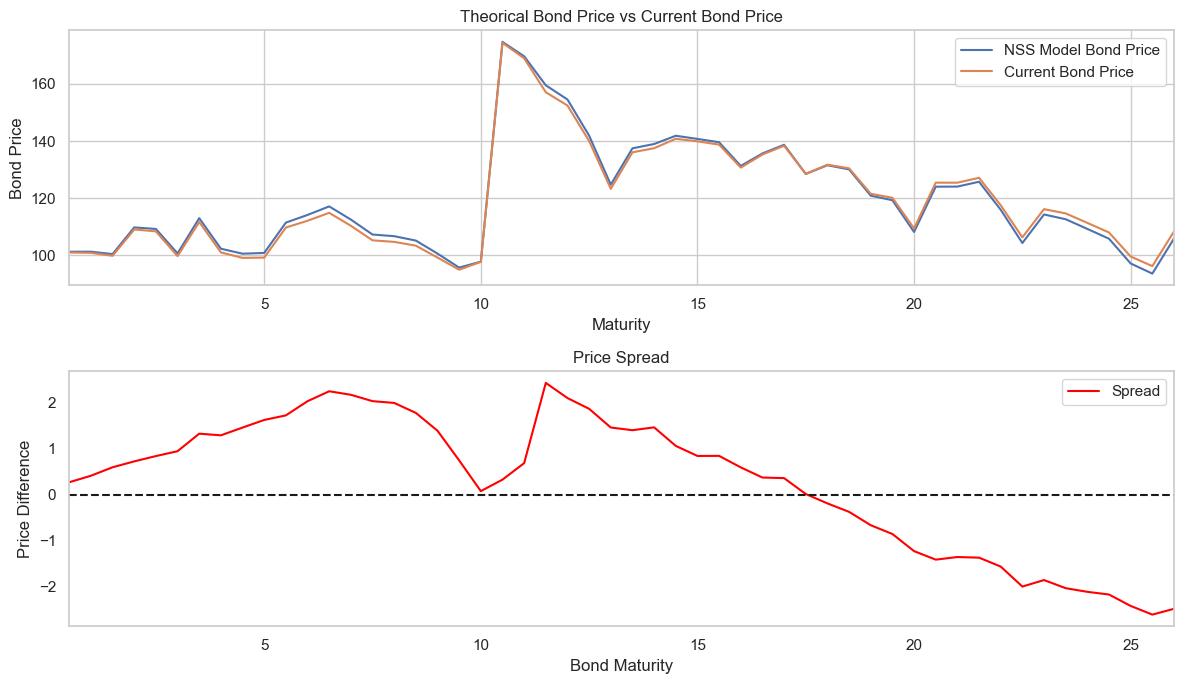

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7))

ax1.plot(df['Maturity'], df['NSS Price'], label='NSS Model Bond Price')
ax1.plot(df['Maturity'], df['Current Price'], label='Current Bond Price')
ax1.set_title('Theorical Bond Price vs Current Bond Price')
ax1.set_xlabel('Maturity')
ax1.set_xlim(df['Maturity'].min(), df['Maturity'].max())
ax1.set_ylabel('Bond Price')
ax1.legend()

ax2.plot(df['Maturity'], df['Spread'], label='Spread', color='red')
ax2.plot(df['Maturity'], np.zeros(df.shape[0]), 'k--')
ax2.set_title('Price Spread')
ax2.set_xlabel('Bond Maturity')
ax2.set_xlim(df['Maturity'].min(), df['Maturity'].max())
ax2.set_ylabel('Price Difference')
ax2.grid()
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The bonds where the spread is positive are undervalued (the current price is lower than the price given by the NSS model), and the bonds where the spread is negative are overvalued (the current price is higher than the price given by the NSS model). Then, the **cheap bonds** are those where the spread is significantly positive : the bonds that have a maturity between **4 years and 9 years and betwen 11 and 12 years**. On the contrary, **the most expensive bonds** are the ones that have a maturity between **22 and 26 years.**

The long/short strategy we propose is based on the following assumptions:

* **Bond Mispricing Correction**: The current mispricing of bonds is expected to dissipate soon, as arbitrageurs who anticipate yield curve steepening like us are likely to adopt similar strategies. Consequently, bond prices should converge toward those previously calculated using the NSS model applied to the expected steepened yield curve.
* **Fractional Bond Investment**: It is possible to invest in fractional units of bonds by purchasing portions of ETFs that track these bonds or by using fractional bond securities offered by certain brokers.
* **No Financing Costs**: We assume that financing costs are zero.

Here is the proposed allocation for the long and short legs:

**Long Leg**: Allocate a weight to each undervalued bond based on the magnitude of its spread relative to the total spread of all undervalued bonds. This approach assigns higher weights to bonds with larger spreads, as these bonds are more likely to adjust toward their expected price.

**Short Leg**: Allocate a weight to each overvalued bond according to the magnitude of its spread relative to the total spread of all overvalued bonds. Consequently, bonds with the largest spreads (in absolute terms) receive the highest weights, reflecting their greater likelihood of price reversion

Long Leg

In [26]:
long_df = df[df['Spread'] >= 0]
long_df['Weight (%)'] = (long_df['Spread'] / long_df['Spread'].sum()) * 100
long_df['Allocated Money ($)'] = round(long_df['Weight (%)'], 4)
long_df['Expected Return (%)'] = (long_df['Spread'] / long_df['Current Price'])
long_df['Weight Adj Expected Return'] = long_df['Expected Return (%)'] * long_df['Weight (%)']

total_weight = round(long_df['Weight (%)'].sum(),2)
long_expecected_return = round(long_df['Weight Adj Expected Return'].sum(),2)

print(f"Total Weight: {total_weight}"+ "%")
print(f'Total Allocation: ${long_df["Allocated Money ($)"].sum()}')
print(f'Expected Return of the Long Leg: {long_expecected_return}%')
print('Long Leg portfolio Compostion:')
long_df[['Maturity','Weight (%)','Allocated Money ($)','Expected Return (%)', 'Weight Adj Expected Return']].sort_values(by='Weight (%)', ascending=False).set_index('Maturity')

Total Weight: 100.0%
Total Allocation: $100.0
Expected Return of the Long Leg: 1.34%
Long Leg portfolio Compostion:


,Weight (%),Allocated Money ($),Expected Return (%),Weight Adj Expected Return
Maturity,,,,
11.5,5.859787,5.8598,0.015466,0.090625
6.5,5.421168,5.4212,0.019556,0.106016
7.0,5.237566,5.2376,0.019667,0.103007
12.0,5.065385,5.0654,0.013775,0.069777
7.5,4.902733,4.9027,0.019301,0.094626
6.0,4.900659,4.9007,0.018114,0.088770
8.0,4.809644,4.8096,0.019031,0.091530
12.5,4.500501,4.5005,0.013324,0.059964
8.5,4.287196,4.2872,0.017180,0.073654


Short Leg

In [27]:
short_df = df[df['Spread'] <= 0]
short_df['Weight (%)'] = - (short_df['Spread'] / short_df['Spread'].sum()) * 100
short_df['Borrowed Money ($)'] = round(short_df['Weight (%)'], 4)
short_df['Expected Return (%)'] = - (short_df['Spread'] / short_df['Current Price'])
short_df['Weight Adj Expected Return'] = - short_df['Expected Return (%)'] * short_df['Weight (%)']

total_weight = round(short_df['Weight (%)'].sum(),2)
short_expecected_return = round(short_df['Weight Adj Expected Return'].sum(),2)

print(f"Total Weight: {total_weight}"+ "%")
print(f'Total Borrowed Money: - ${-round(short_df["Borrowed Money ($)"].sum(),2)}')
print(f'Expected Return of the Short Leg: {short_expecected_return}%')
print('Short Leg portfolio Compostion:')
short_df[['Maturity','Weight (%)','Borrowed Money ($)','Expected Return (%)', 'Weight Adj Expected Return']].sort_values(by='Weight (%)').set_index('Maturity')

Total Weight: -100.0%
Total Borrowed Money: - $100.0
Expected Return of the Short Leg: 1.74%
Short Leg portfolio Compostion:


,Weight (%),Borrowed Money ($),Expected Return (%),Weight Adj Expected Return
Maturity,,,,
25.5,-9.763468,-9.7635,0.027114,0.264724
26.0,-9.294690,-9.2947,0.022926,0.213094
25.0,-9.059969,-9.0600,0.024315,0.220295
24.5,-8.130858,-8.1309,0.020124,0.163624
24.0,-7.911724,-7.9117,0.018990,0.150244
23.5,-7.615367,-7.6154,0.017752,0.135189
22.5,-7.483558,-7.4836,0.018814,0.140793
23.0,-6.953979,-6.9540,0.016002,0.111281
22.0,-5.855878,-5.8559,0.013321,0.078003


Final Comments

In [28]:
total_expected_return = long_expecected_return + short_expecected_return
print(f'Total Expected Return: {total_expected_return} %')

Total Expected Return: 3.08 %


The expected return of our long/short strategy is **3.08%**.

The strategy could be improved in several ways, notably:

* The short leg is less diversified than the long leg, as its components are concentrated in maturities exceeding 20 years.
* We could apply more selectivity in allocation, particularly for the long leg, since some bonds with insignificant mispricings are currently included. However, this would reduce portfolio diversification.